In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve, train_test_split

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

!pip install catboost
!pip install xgboost
!pip install lightgbm

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [44]:
data=pd.read_csv("customer_data.csv")
data_=data.copy()

In [4]:
y = data["Attrition_Flag"]
X = data.drop(["Attrition_Flag"], axis=1)

## Random Forest

In [6]:
rf_model = RandomForestClassifier(random_state=17)
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [7]:
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [8]:
cv_results['test_accuracy'].mean()

0.9413435613701718

In [9]:
cv_results['test_f1'].mean()

0.8047402580195786

In [10]:
cv_results['test_roc_auc'].mean()

0.9612336768381518

In [64]:
#Hyperparameter optimization
rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7,8,9,10,15 ,"auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

In [23]:
rf_random = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=rf_random_params,
                               n_iter=100,  
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)

In [24]:
rf_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([24, 26, 35, 34, 36, 32, 46, 42, 28, 47]),
                                        'max_features': [3, 5, 7, 8, 9, 10, 15,
                                                         'auto', 'sqrt'],
                                        'min_samples_split': array([31, 27, 26, 33,  8, 21, 10, 44, 45,  2, 44,  9, 19,  4, 11,  9,  2,
        3,  2, 35]),
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=True)

In [25]:
rf_random.best_params_

{'n_estimators': 488,
 'min_samples_split': 2,
 'max_features': 7,
 'max_depth': 34}

In [29]:
f_params = {"max_depth": [33,34,35,38],
             "max_features": [6,7,8],
             "min_samples_split": range(2,5),
             "n_estimators": [488,450,500,490,550]}


In [31]:
rf_best_grid = GridSearchCV(rf_model,
                              f_params,
                              cv=3,
                              n_jobs=-1,
                              verbose=1).fit(X, y)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


In [32]:
rf_best_grid.best_params_

{'max_depth': 33,
 'max_features': 7,
 'min_samples_split': 2,
 'n_estimators': 488}

In [33]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

In [34]:
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.9447006114191401

In [35]:
cv_results['test_f1'].mean()

0.8224051583536178

In [36]:
cv_results['test_roc_auc'].mean()

0.9648566591371835

## Smote + Random Forest

In [45]:
data_.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Transaction_Count_per_Contact,Loyal_Customer,Creditworthiness,Cr_Util_Rate,Attrition_Flag
0,0.0,-1.0,0.5,-1.0,1.0,0.5,0.0,0.0,0.5,-1.0,1.0,0.956476,-0.350175,0.988927,2.627193,-1.065558,-0.694444,3.911017,-0.239583,-0.500000,0.0,-0.284692,-0.238398,0
1,0.0,0.0,1.5,0.0,0.0,-0.5,0.0,0.0,1.0,-1.0,0.0,0.435477,-0.289123,0.459078,3.530702,-1.008702,-0.944444,12.762712,-0.147917,-0.666667,0.0,-0.618989,-0.147921,0
2,0.0,-1.0,0.5,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,-2.0,-0.132863,-0.895439,-0.006562,8.149123,-0.778186,-1.305556,6.911017,-0.366667,-0.907407,0.0,2.281101,-0.365955,0
3,-1.0,0.0,1.0,-1.0,0.0,-0.5,0.0,-1.0,-0.5,2.0,-1.0,-0.145198,0.870877,-0.313785,2.934211,-1.055115,-1.305556,6.911017,1.216667,-0.537037,-1.0,-0.228374,1.216900,0
4,-1.0,-1.0,0.5,-1.0,1.0,0.5,0.0,-2.0,0.5,-1.0,-2.0,0.019618,-0.895439,0.145527,6.311404,-1.192419,-1.083333,7.618644,-0.366667,-1.277778,-1.0,0.723351,-0.365955,0


In [46]:
y = data_["Attrition_Flag"]
X = data_.drop(["Attrition_Flag"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [47]:
sm = SMOTE(random_state = 1, sampling_strategy = 1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [49]:
rf_model = RandomForestClassifier(random_state=17)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

In [50]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1695
           1       0.89      0.87      0.88       331

    accuracy                           0.96      2026
   macro avg       0.93      0.93      0.93      2026
weighted avg       0.96      0.96      0.96      2026



In [51]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [52]:
rf_random_params_ = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7,8,9,10,15 ,"auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

In [54]:
rf_random_ = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=rf_random_params,
                               n_iter=100,  
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)

In [55]:
rf_random_.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([24, 26, 35, 34, 36, 32, 46, 42, 28, 47]),
                                        'max_features': [3, 5, 7, 8, 9, 10, 15,
                                                         'auto', 'sqrt'],
                                        'min_samples_split': array([31, 27, 26, 33,  8, 21, 10, 44, 45,  2, 44,  9, 19,  4, 11,  9,  2,
        3,  2, 35]),
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=True)

In [56]:
rf_random_.best_params_

{'n_estimators': 344,
 'min_samples_split': 2,
 'max_features': 'sqrt',
 'max_depth': 26}

In [59]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_train, y_train)

In [60]:
y_pred = rf_final.predict(X_test)

In [62]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9639684106614018


In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1695
           1       0.88      0.90      0.89       331

    accuracy                           0.96      2026
   macro avg       0.93      0.94      0.93      2026
weighted avg       0.96      0.96      0.96      2026



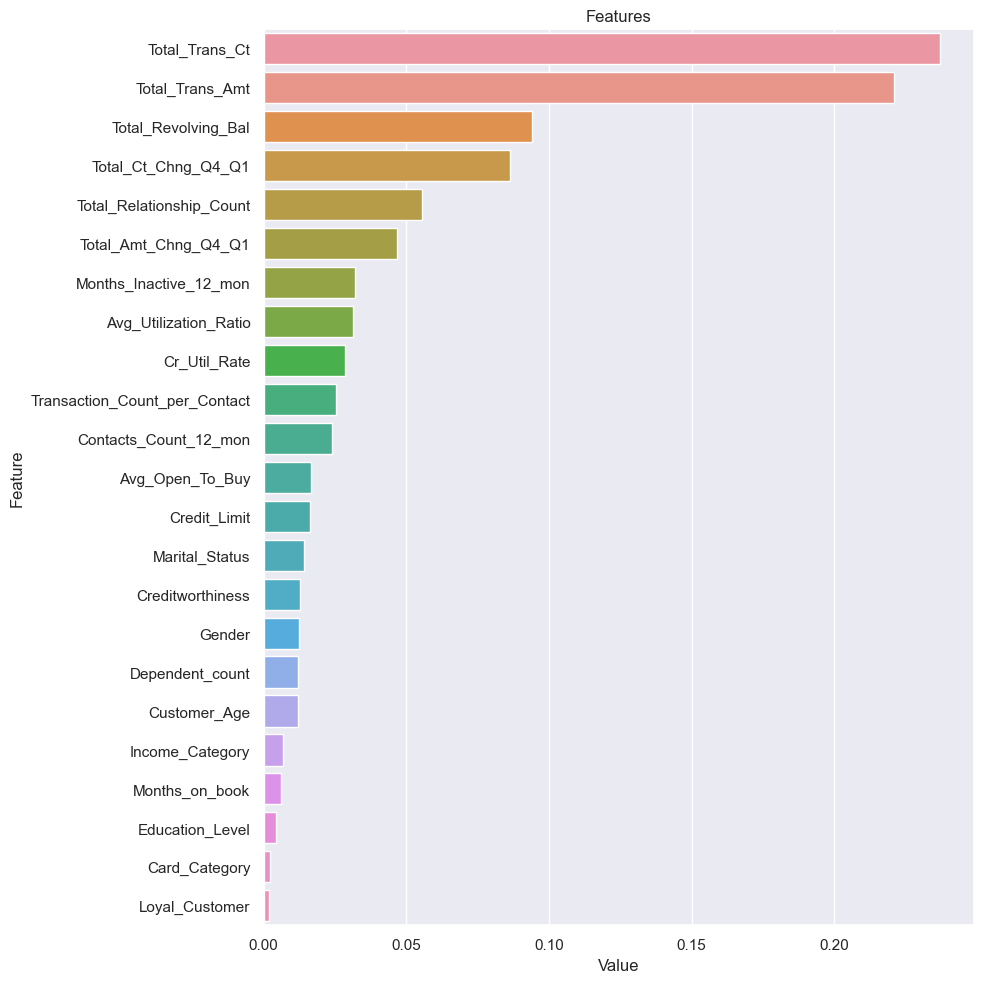

In [71]:
#Feature importance

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)